<a href="https://colab.research.google.com/github/NicoleGilLopez/NicoleGil/blob/main/MIS545_Data_Decoders_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicting Total EQ Units for Granola Bar Product Sales Using Machine Learning***

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/MIS 545/Project/granolabar_dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Item,Brand,Sub-Category,UPC,Category,Sales Rank,Item Rank,Item Status (New/Existing/dropped),Item Ranking Segment,$ Sales,...,Total Distribution Points Year-Ago,Distribution Points % Change vs. Year-Ago,Average Number of Stores Selling per Week,Velocity ($/TDP),Velocity ($/TDP) Year-Ago,Total EQ Units,Total EQ Units Year Ago,Total EQ Units % Change vs Year Ago,Velocity ($/TDP) % Change vs. Year-Ago,% of Category Distribution
0,KND BRKF BAR PNT BTR BNN DRK CHCL WRP IN BOX 6 CT,KIND (KIND LLC),GLUTEN FREE BREAKFAST CEREAL BARS,60265241931,CEREAL AND GRANOLA BARS,13,1,Existing,Best in Class,$15.0 M,...,47.3,30.0%,"10,967",$4.7 K,$4.0 K,15.5 M,10.3 M,50.6%,16.3%,0.8%
1,NTR VLY CRSP CRMY WFR BAR PNT BTR CHCL BAG IN ...,NATURE VALLEY (GENERAL MILLS),GRANOLA BARS,1600020103,CEREAL AND GRANOLA BARS,62,2,Existing,Best in Class,$5.0 M,...,4.5,327.4%,"3,105",$5.0 K,$4.4 K,7.3 M,1.5 M,386.2%,13.1%,0.2%
2,KND BRKF BAR DRK CHCL CC WRP IN BOX 12 CT,KIND (KIND LLC),GLUTEN FREE BREAKFAST CEREAL BARS,60265241930,CEREAL AND GRANOLA BARS,9,3,Existing,Best in Class,$16.5 M,...,60.9,8.6%,"12,347",$4.8 K,$4.4 K,34.2 M,28.9 M,18.4%,7.6%,0.8%
3,KDK GRNL BAR SMRS WRP IN BOX 5 CT,KODIAK (KODIAK CAKES),GRANOLA BARS,70559901641,CEREAL AND GRANOLA BARS,23,4,Existing,Best in Class,$11.8 M,...,44.2,22.5%,"9,701",$4.2 K,$3.8 K,11.1 M,8.4 M,33.0%,9.3%,0.7%
4,NTR VLY SWT SLTY NUT GRNL BAR DRK CHCL PNT ALM...,NATURE VALLEY (GENERAL MILLS),GRANOLA BARS,1600027855,CEREAL AND GRANOLA BARS,5,5,Existing,Best in Class,$20.3 M,...,77.0,1.7%,"18,730",$5.0 K,$4.9 K,40.1 M,38.0 M,5.6%,1.7%,1.0%


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Define Dataset, Load Data, Number Cleaning, and Set Target

def clean_numeric_strong(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()

    # Remove $, commas, %, spaces
    x = x.replace('$', '').replace(',', '').replace('%', '').strip()

    # Handle MILLIONS (M)
    if x.upper().endswith('M'):
        return float(x[:-1]) * 1_000_000

    # Handle THOUSANDS (K)
    if x.upper().endswith('K'):
        return float(x[:-1]) * 1_000

    # Default conversion
    try:
        return float(x)
    except:
        return np.nan

numeric_cols = [
    '$ Sales', 'Unit Sales', 'Average Price', 'Velocity ($/TDP)',
    'Total EQ Units', 'Total EQ Units Year Ago',
    'Unit Sales % Change', 'Sales % Change', 'Unit Sales Year-Ago'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_numeric_strong)


## ***Exploratory Data Analysis (EDA)***



In [8]:
# Summary KPIs

total_sales = df['$ Sales'].sum()
total_units = df['Unit Sales'].sum()
avg_price = df['Average Price'].mean()
avg_velocity = df['Velocity ($/TDP)'].mean()

print("Total Sales ($):", round(total_sales, 2))
print("Total Units:", round(total_units, 2))
print("Average Price:", round(avg_price, 2))
print("Average Velocity:", round(avg_velocity, 2))

Total Sales ($): 1181233548.2
Total Units: 301719279.5
Average Price: 4.41
Average Velocity: 3089.81


TOP 10 ITEMS:
                                                  Item     $ Sales
5        NTR VLY GRNL BAR OATS N HNY WRP IN BOX 12 CT  32700000.0
17    KLGS RC KRS TRT CRSP ORGN MRSH WRP IN BOX 40 CT  26000000.0
18               KLGS RC KRS TRT CRSP WRP IN BOX 8 CT  22900000.0
13         KLGS NTR GRN BRKF BAR STRW WRP IN BOX 8 CT  21200000.0
4   NTR VLY SWT SLTY NUT GRNL BAR DRK CHCL PNT ALM...  20300000.0
26              KLGS RC KRS TRT CRSP WRP IN BOX 16 CT  18000000.0
21  NTR VLY SWT SLTY NUT GRNL BAR PNT WRP IN BOX 6 CT  16600000.0
14  NTR VLY SWT SLTY NUT GRNL BAR CSHW ALMN BTR WR...  16600000.0
2           KND BRKF BAR DRK CHCL CC WRP IN BOX 12 CT  16500000.0
28  NTR VLY SWT SLTY NUT GRNL BAR ALMN BTR WRP IN ...  15800000.0


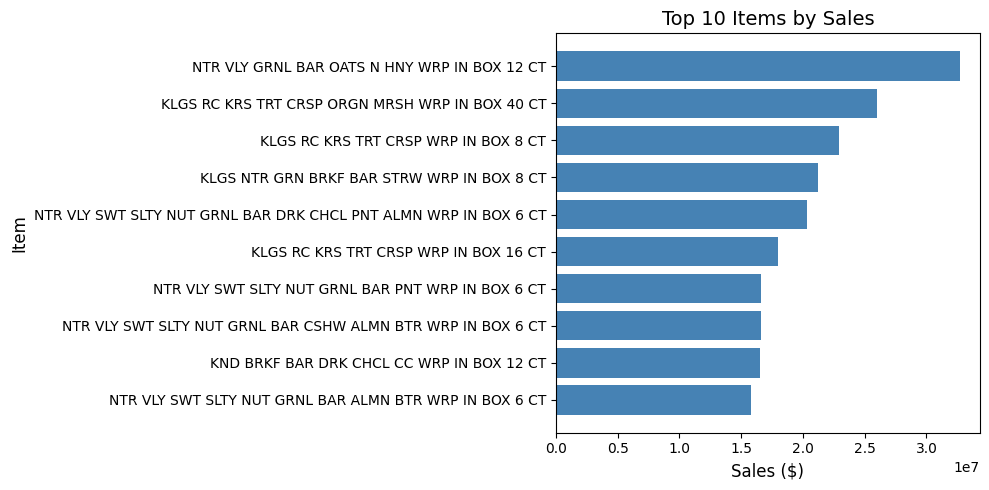

In [9]:
# Sales Visual (Top 10 Items)
top10_sales = (
    df[['Item', '$ Sales']]
    .dropna()
    .sort_values('$ Sales', ascending=False)
    .head(10)
)

print("TOP 10 ITEMS:\n", top10_sales)

# Plot Fig
plt.figure(figsize=(10,5))
plt.barh(top10_sales['Item'], top10_sales['$ Sales'], color='steelblue')
plt.title("Top 10 Items by Sales", fontsize=14)
plt.xlabel("Sales ($)", fontsize=12)
plt.ylabel("Item", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



BOTTOM 5 ITEMS:
                                                   Item  $ Sales
1336           KLGS RC KRS TRT CRSP MRSH BOX 6PK 16 CT      0.0
1361  LTL DB CRSP RC BAR CHCL CHP MRSH WRP IN BOX 8 CT      0.1
1319                        QKR GRNL BAR CNMN BAG 1 CT      0.3
1312                CTL BR GRNL BAR CHCL CHP BOX 10 CT      0.5
1332              PRLY ELZ GRNL BAR CCNT CSHW WRP 1 CT      0.5


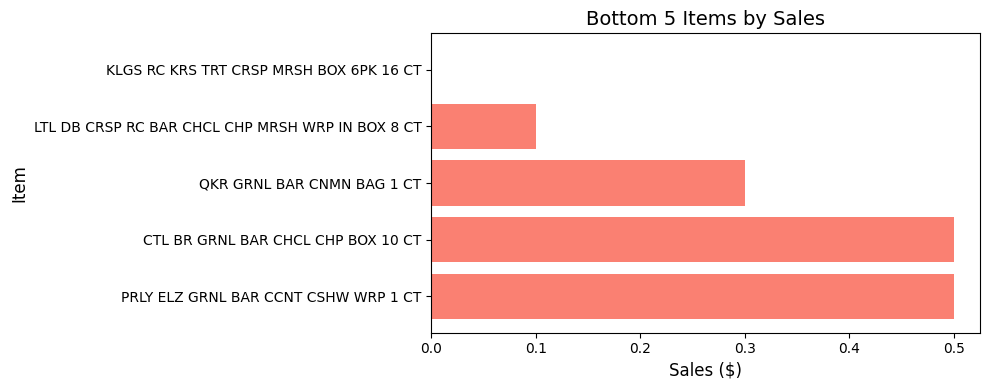

In [10]:
# Sales Visual (Bottom 5 Items)

bottom5_sales = (
    df[['Item', '$ Sales']]
    .dropna()
    .sort_values('$ Sales', ascending=True)
    .head(5)
)

print("\nBOTTOM 5 ITEMS:\n", bottom5_sales)

# Plot Fig
plt.figure(figsize=(10,4))
plt.barh(bottom5_sales['Item'], bottom5_sales['$ Sales'], color='salmon')
plt.title("Bottom 5 Items by Sales", fontsize=14)
plt.xlabel("Sales ($)", fontsize=12)
plt.ylabel("Item", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Brand Insights

df['Brand'] = df['Brand'].astype(str).str.strip()

num_brands = df['Brand'].nunique()
print("Number of brands:", num_brands)

brand_sales = df.groupby('Brand')['$ Sales'].sum().sort_values(ascending=False)
top_brand = brand_sales.head(1)
print("\nTop Brand:\n", top_brand)

Number of brands: 141

Top Brand:
 Brand
NATURE VALLEY (GENERAL MILLS)    353546429.4
Name: $ Sales, dtype: float64


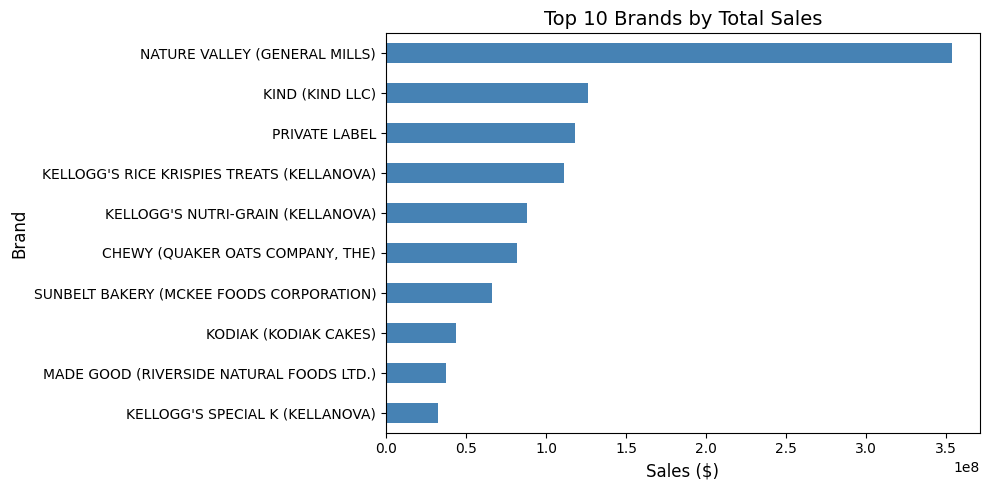

In [12]:
# Top 10 Brands by Total Sales

top10 = brand_sales.head(10)

plt.figure(figsize=(10,5))
top10.plot(kind='barh', color='steelblue')

plt.title("Top 10 Brands by Total Sales", fontsize=14)
plt.xlabel("Sales ($)", fontsize=12)
plt.ylabel("Brand", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [13]:
# Growth Analysis

df['Unit Sales Year-Ago'] = df['Unit Sales Year-Ago'].replace(0, np.nan)

df['Growth'] = (
    (df['Unit Sales'] - df['Unit Sales Year-Ago']) /
    df['Unit Sales Year-Ago']
)

positive_growth = (df['Growth'] > 0).sum()
negative_growth = (df['Growth'] < 0).sum()

print("Items with Positive Growth:", positive_growth)
print("Items with Negative Growth:", negative_growth)

Items with Positive Growth: 407
Items with Negative Growth: 686


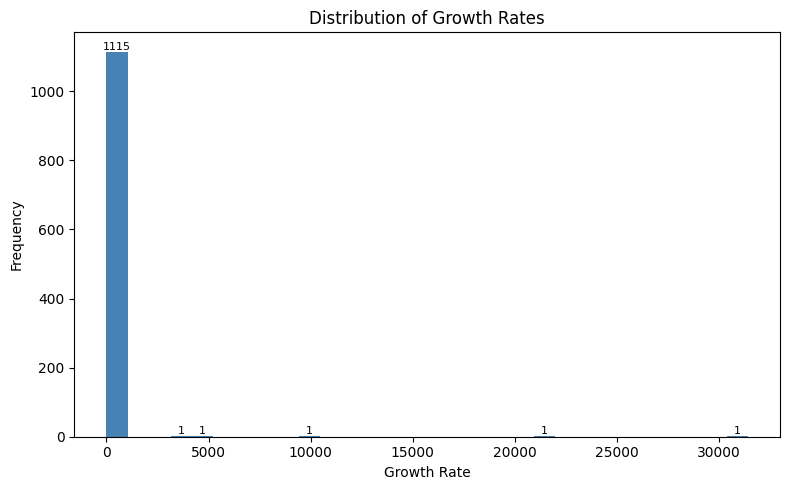

In [14]:
# Growth Rates Distribution Visual

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(df['Growth'], bins=30, color='steelblue')

# Add labels on top of bars
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("Distribution of Growth Rates")
plt.xlabel("Growth Rate")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



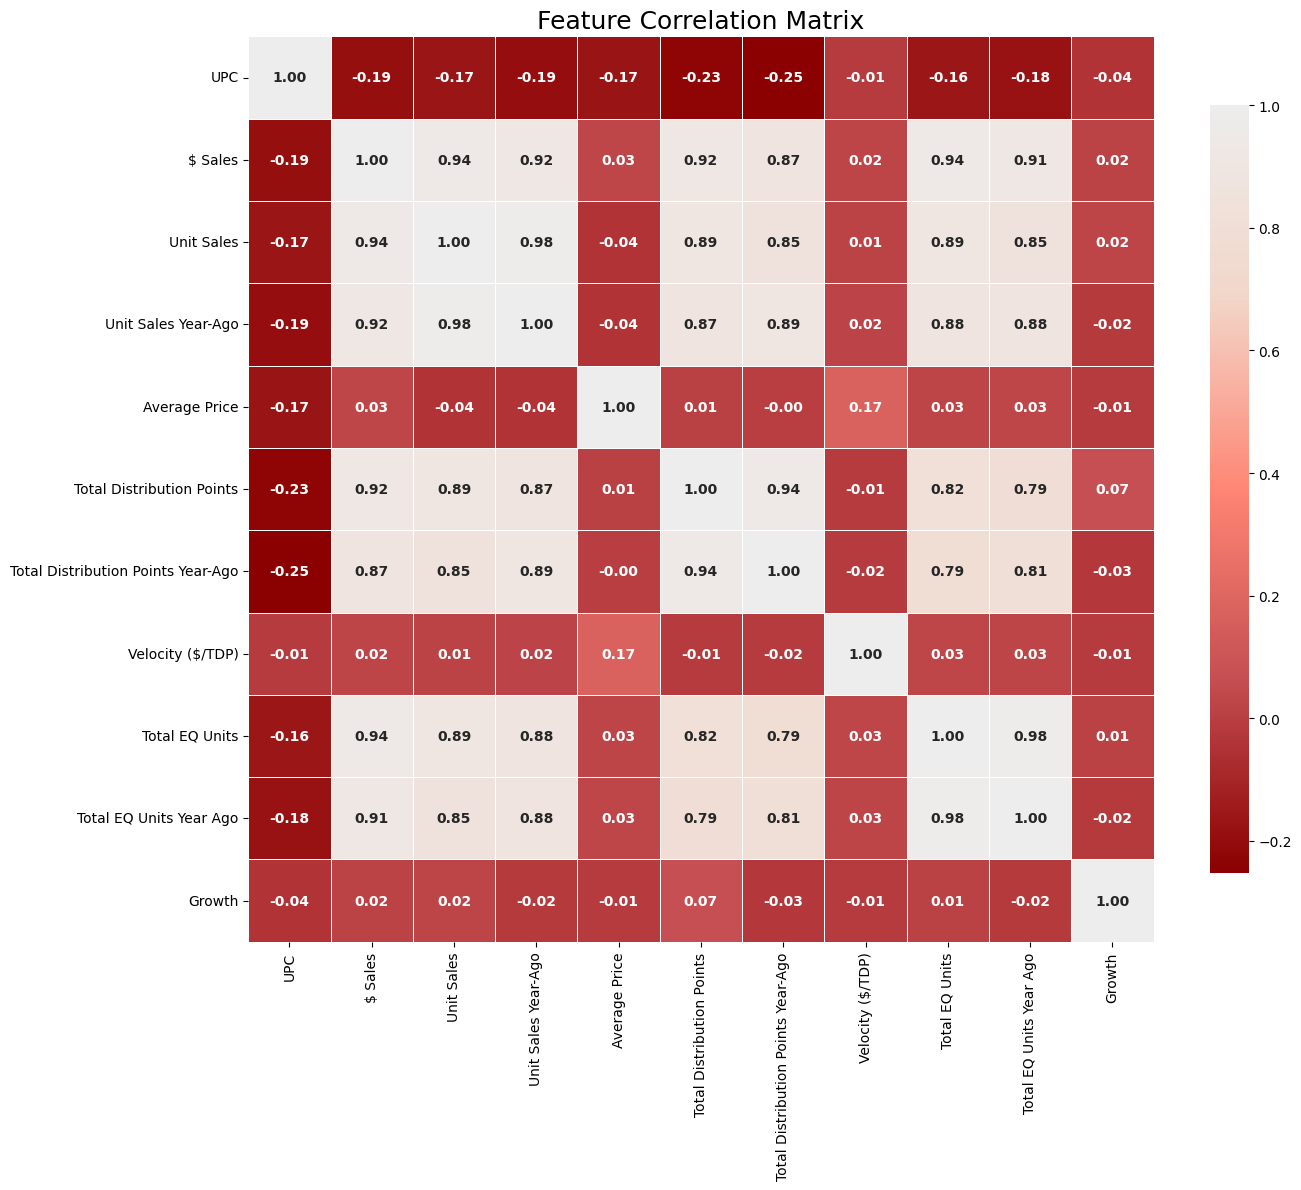

In [15]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#8B0000",  # deep red
    "#C44E52",  # medium red/salmon
    "#FF8674",  # light salmon
    "#F2D6C9",  # peach
    "#EDEDED"   # light grey/beige
]

custom_redsoft = LinearSegmentedColormap.from_list("custom_redsoft", colors)

corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap=custom_redsoft,
    annot=True,
    fmt=".2f",
    annot_kws={"weight": "bold"},
    square=True,
    linewidths=.4,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Matrix", fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



In [16]:
# Train/Test Split + ColumnTransformer

target_col = 'Total EQ Units'
df = df.dropna(subset=[target_col])

id_cols = ['Item', 'Brand', 'UPC']
id_cols = [c for c in id_cols if c in df.columns]

X = df.drop(columns=[target_col] + id_cols)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    [('num', numeric_transformer, numeric_features),
     ('cat', categorical_transformer, categorical_features)]
)

In [17]:
# Linear Regression Pipeline
from sklearn.impute import SimpleImputer

# Redefine the preprocessor to include SimpleImputer for numeric and categorical features
# We use pipelines within the ColumnTransformer for each type of feature

numeric_transformer_with_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_with_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Recreate the ColumnTransformer using the new transformers
# numeric_features and categorical_features are already available in the kernel state

preprocessor_with_imputation = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_with_imputer, numeric_features),
        ('cat', categorical_transformer_with_imputer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns that are not transformed
)

lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_with_imputation),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mape = mean_absolute_percentage_error(y_test, lr_pred)

print("Linear Regression:")
print("RMSE:", lr_rmse)
print("MAE:", lr_mae)
print("MAPE:", lr_mape)

Linear Regression:
RMSE: 699463.3097522944
MAE: 354484.1533527089
MAPE: 2655.6084622558924


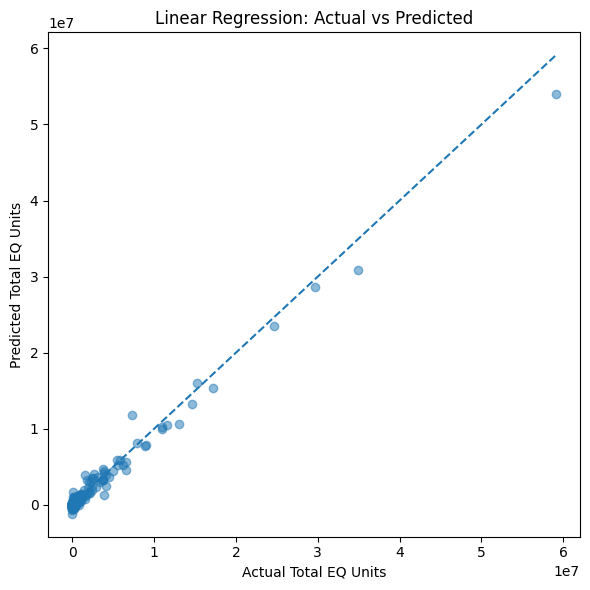

In [18]:
# Linear Regression Visual (Actual vs Predicted)

plt.figure(figsize=(6,6))
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel('Actual Total EQ Units')
plt.ylabel('Predicted Total EQ Units')
plt.title('Linear Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()

In [20]:
# Random Forest Pipeline

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_with_imputation), # Use the preprocessor with imputation
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)

print("Random Forest:")
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print("MAPE:", rf_mape)

Random Forest:
RMSE: 881869.2695868439
MAE: 252078.98237118442
MAPE: 0.8952705843464426


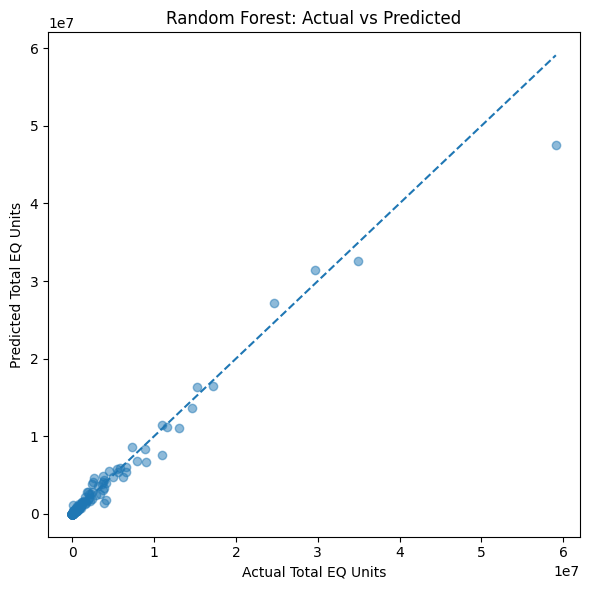

In [21]:
# Random Forest Visual (Actual vs Predicted)

plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel('Actual Total EQ Units')
plt.ylabel('Predicted Total EQ Units')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

In [22]:
# Random Forest Hyperparameter Tuning

param_dist = {
    'model__n_estimators': [200, 300, 400, 500, 600],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'] # Removed 'auto' as it's no longer valid
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)
best_rf = rf_random_search.best_estimator_

tuned_pred = best_rf.predict(X_test)

tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_pred)) # Calculate RMSE manually
tuned_mape = mean_absolute_percentage_error(y_test, tuned_pred)

print("Tuned RF RMSE:", tuned_rmse)
print("Tuned RF MAPE:", tuned_mape*100)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned RF RMSE: 2638765.6015487355
Tuned RF MAPE: 796071.5347376548


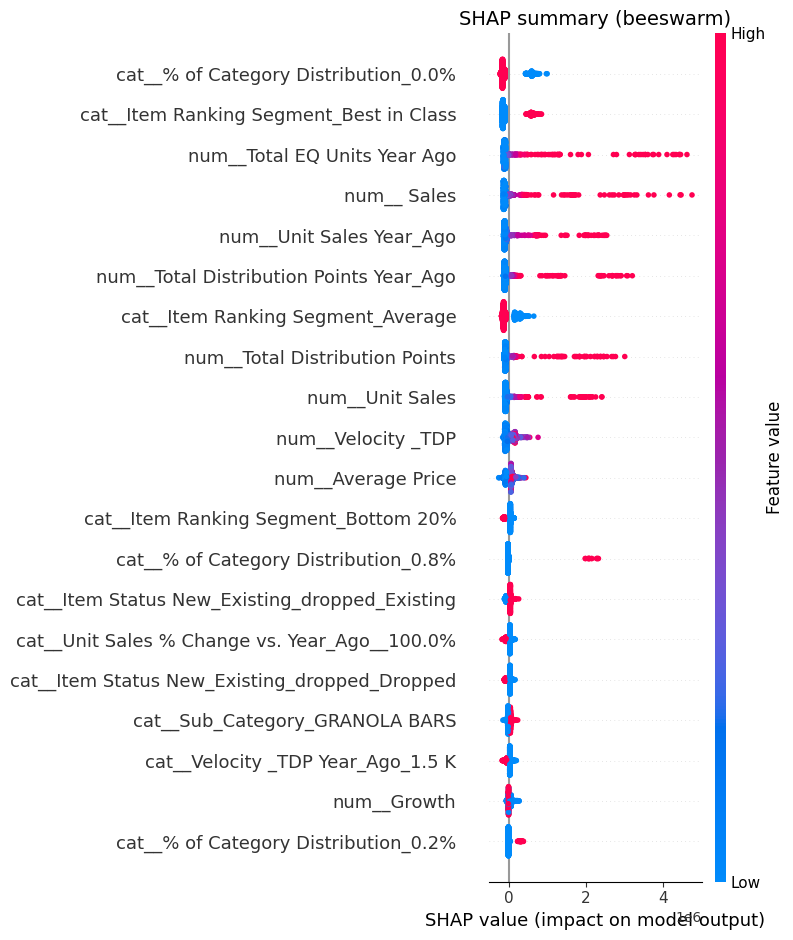

In [23]:
# SHAP on Random Forest

import shap
shap.initjs()

# Shap_values
rf_model = best_rf.named_steps['model']
X_train_transformed = best_rf.named_steps['preprocess'].transform(X_train).toarray()
feature_names = best_rf.named_steps['preprocess'].get_feature_names_out()
sanitized_feature_names = [n.replace('$','').replace('(','').replace(')','').replace('/','_').replace('-','_')
                           for n in feature_names]
X_train_shap = pd.DataFrame(X_train_transformed, columns=sanitized_feature_names)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_shap)


# Plot 1: Beeswarm / dot summary ----

plt.close('all')
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values, X_train_shap, show=False)
plt.title("SHAP summary (beeswarm)", fontsize=14)
plt.tight_layout()
plt.show()


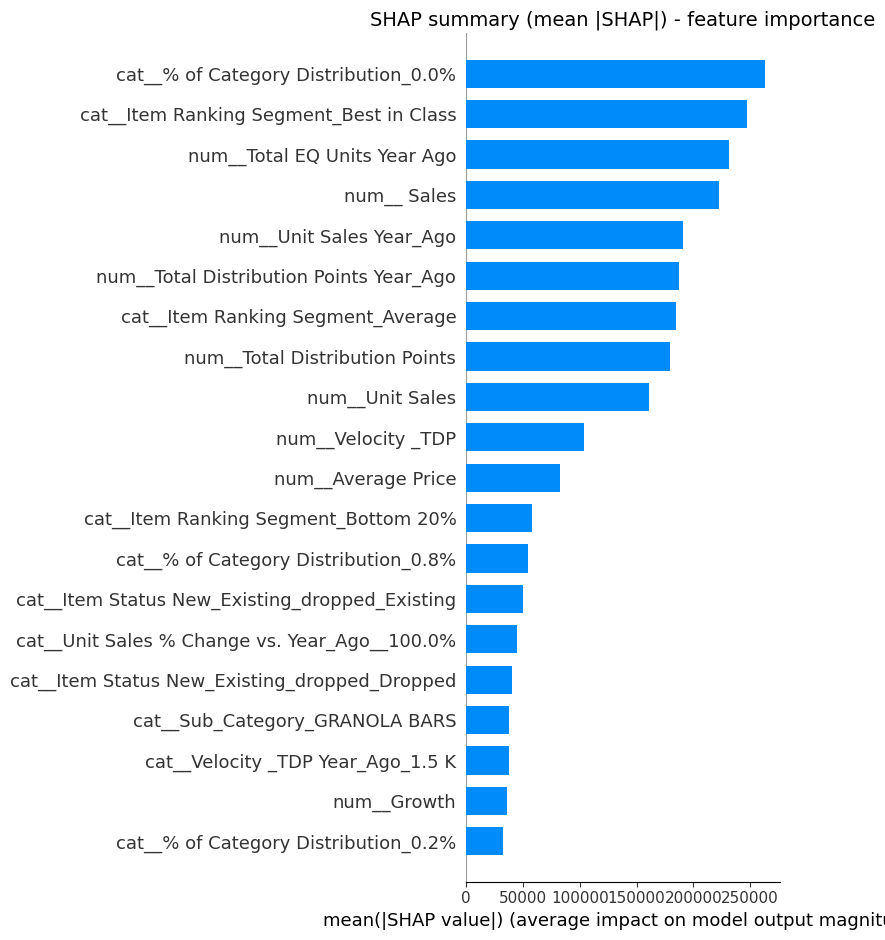

In [24]:
# Plot 2: Bar summary ----

plt.close('all')
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values, X_train_shap, plot_type='bar', show=False)
plt.title("SHAP summary (mean |SHAP|) - feature importance", fontsize=14)
plt.tight_layout()
plt.show()


In [25]:
# MLP Artificial Neural Network

X_train_nn = preprocessor_with_imputation.transform(X_train)
X_test_nn = preprocessor_with_imputation.transform(X_test)

input_dim = X_train_nn.shape[1]

tf.random.set_seed(42)

mlp = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp.compile(optimizer='adam', loss='mse')

history = mlp.fit(
    X_train_nn,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_pred = mlp.predict(X_test_nn).flatten()

mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_mape = mean_absolute_percentage_error(y_test, mlp_pred)

print("MLP ANN RMSE:", mlp_rmse)
print("MLP ANN MAPE:", mlp_mape*100)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MLP ANN RMSE: 5475052.902492456
MLP ANN MAPE: 72268.36463785102


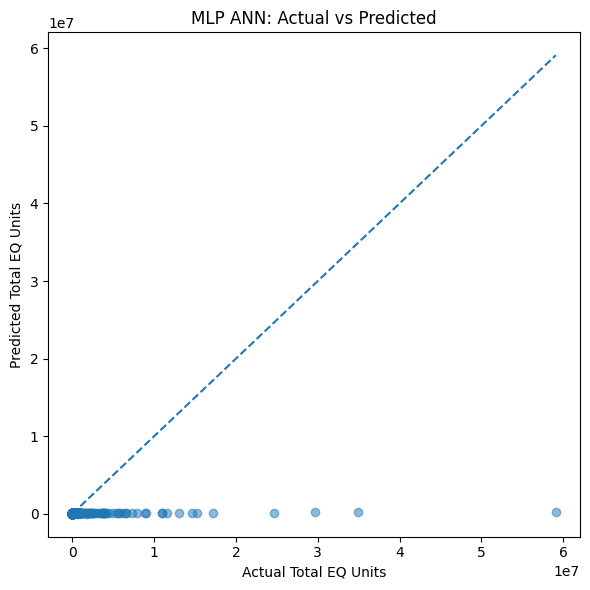

In [26]:
# ANN Visual (Actual vs Predicted)

plt.figure(figsize=(6,6))
plt.scatter(y_test, mlp_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel('Actual Total EQ Units')
plt.ylabel('Predicted Total EQ Units')
plt.title('MLP ANN: Actual vs Predicted')
plt.tight_layout()
plt.show()

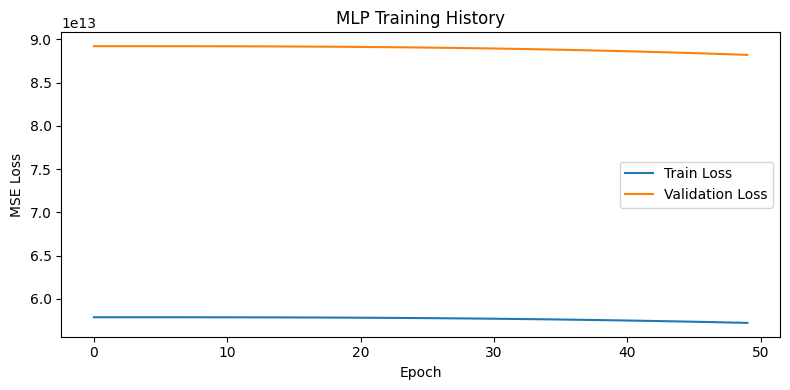

In [27]:
# Training Loss Plot

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MLP Training History')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Model Comparison

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'MLP ANN'],
    'RMSE': [lr_rmse, rf_rmse, mlp_rmse],
    'MAE':  [lr_mae,  rf_mae,  mlp_mae],
    'MAPE (%)': [lr_mape*100, rf_mape*100, mlp_mape*100]
})

print(results)

               Model          RMSE           MAE       MAPE (%)
0  Linear Regression  6.994633e+05  3.544842e+05  265560.846226
1      Random Forest  8.818693e+05  2.520790e+05      89.527058
2            MLP ANN  5.475053e+06  1.607853e+06   72268.364638
